# 🇮🇳🧠📈 Multi-Agent Financial Analysis System (NSE / India Edition)

**Goal:** Agentic AI system for Indian equity research (NSE) using autonomous agents and workflow patterns. Runs end-to-end in Google Colab with **mock fallbacks** (no API keys required). Example ticker: `RELIANCE.NS`.

## System Architecture & Agent Roles

**Core Components**
1. **InvestmentResearchAgent (autonomous):**
   - Plans research steps per NSE stock symbol.
   - Dynamically calls tools: *Finance (yfinance .NS)*, *News (mock India)*, *Macro (mock RBI/FRED-India)*.
   - Performs **self-reflection** (Evaluator) and **refinement** (Optimizer).
   - **Learns across runs** via a simple JSON memory (`/content/agent_memory_nse.json`).

2. **Specialist Agents (for routing):**
   - **EarningsAgent:** parses earnings-related info (EPS surprises, guidance, capex, PLI mentions).
   - **NewsAgent:** **prompt-chaining pipeline** → *Ingest → Preprocess → Classify → Extract → Summarize* tuned for India (SEBI/RBI/regulatory cues).
   - **MarketAgent:** macro & market color using mock series: CPI (India), WPI, **RBI Repo Rate**, **USDINR**.

3. **Workflow Patterns**
- **Prompt Chaining** (News): Ingest → Clean/Tokenize → Classify (bullish/bearish/neutral) → Extract signals → Summarize.
- **Routing:** Content router dispatches snippets to: *earnings* / *news*.
- **Evaluator–Optimizer:** Draft analysis → Evaluate (coverage, consistency, actionability) → Refine using feedback.

4. **Data Flow**
```
Ticker → Plan → Finance Tool (prices, returns) → India News (mock) → Router →
  EarningsAgent / NewsAgent / MarketAgent → Draft → Evaluator → Optimizer → Final Report
```

5. **👥 Team Contributions**

Pavan Kumar Kallakuri – Agent Design & Workflow Implementation

Designed InvestmentResearchAgent including planning logic, run loop, and memory keeper.
Built prompt-chaining NewsAgent and routing logic.
Led evaluator–optimizer integration and refinement.
Drafted system architecture and internal documentation.
Sajesh Kariadan – Data Integration & Reporting

Developed tool wrappers for yfinance (NSE), mock Indian news, and RBI macroeconomic data.
Created fallback data generators and visualizations.
Implemented reporting structure and export functions (PDF/HTML).
Managed GitHub repository and version control.

---
✅ *Self-contained and runs without API keys (uses mock data fallbacks).*


In [1]:
# =============================================================
# Setup & Imports (PEP 8 friendly; safe fallbacks for offline)
# =============================================================
from __future__ import annotations
import json
import os
import re
import math
from typing import List, Dict, Any
import datetime as dt
import random

import pandas as pd
import matplotlib.pyplot as plt

try:
    import yfinance as yf
    YF_AVAILABLE = True
except Exception:
    YF_AVAILABLE = False

MEMORY_PATH = "/content/agent_memory_nse.json"

pd.set_option("display.width", 120)
pd.set_option("display.max_colwidth", 120)

## Utilities & Lightweight Memory (India Edition)
A tiny JSON memory to persist notes across runs. Stores lessons per NSE ticker.

In [2]:
def load_memory(path: str = MEMORY_PATH) -> Dict[str, Any]:
    if os.path.exists(path):
        try:
            with open(path, "r", encoding="utf-8") as f:
                return json.load(f)
        except Exception:
            return {"notes": {}, "runs": 0}
    return {"notes": {}, "runs": 0}

def save_memory(memory: Dict[str, Any], path: str = MEMORY_PATH) -> None:
    with open(path, "w", encoding="utf-8") as f:
        json.dump(memory, f, indent=2)

def memorize(ticker: str, note: str) -> None:
    memory = load_memory()
    memory.setdefault("notes", {}).setdefault(ticker.upper(), [])
    if note not in memory["notes"][ticker.upper()]:
        memory["notes"][ticker.upper()].append(note)
    memory["runs"] = memory.get("runs", 0) + 1
    save_memory(memory)

def recall(ticker: str) -> List[str]:
    memory = load_memory()
    return memory.get("notes", {}).get(ticker.upper(), [])

## Mock Data (India News & Macro)
Indian market-focused mock datasets to ensure offline execution.

In [3]:
MOCK_NEWS_INDIA = [
    {
        "title": "RIL announces green energy capex ramp-up; evaluates battery storage JV",
        "published": "2025-09-14",
        "content": "Reliance plans incremental capex towards solar PV and battery storage; analysts expect margin expansion in new energy over FY26-27.",
        "type": "capex"
    },
    {
        "title": "RBI keeps repo rate unchanged; stance remains withdrawal of accommodation",
        "published": "2025-09-10",
        "content": "Sticky food inflation noted; liquidity fine-tuning to continue; commentary supportive of growth.",
        "type": "macro"
    },
    {
        "title": "Reliance beats estimates on retail and Jio growth",
        "published": "2025-08-01",
        "content": "Consolidated EPS beat by ₹2; ARPU up; retail footfalls robust; O2C margins stable.",
        "type": "earnings"
    },
    {
        "title": "SEBI proposes tweaks to related-party norms for large conglomerates",
        "published": "2025-07-25",
        "content": "Consultation paper floats higher disclosure thresholds; potential compliance costs for diversified groups.",
        "type": "regulatory"
    },
]

MOCK_MACRO_INDIA = {
    "CPI_YOY_IND": [
        {"date": "2025-05-01", "value": 5.1},
        {"date": "2025-06-01", "value": 5.0},
        {"date": "2025-07-01", "value": 4.9},
        {"date": "2025-08-01", "value": 4.8},
    ],
    "WPI_YOY": [
        {"date": "2025-05-01", "value": 1.8},
        {"date": "2025-06-01", "value": 2.1},
        {"date": "2025-07-01", "value": 2.3},
        {"date": "2025-08-01", "value": 2.2},
    ],
    "RBI_REPO": [
        {"date": "2025-07-01", "value": 6.50},
        {"date": "2025-08-01", "value": 6.50},
        {"date": "2025-09-01", "value": 6.50},
    ],
    "USDINR": [
        {"date": "2025-06-01", "value": 84.2},
        {"date": "2025-07-01", "value": 83.9},
        {"date": "2025-08-01", "value": 83.6},
    ]
}

pd.DataFrame(MOCK_NEWS_INDIA)

,title,published,content,type
0,RIL announces green energy capex ramp-up; evaluates battery storage JV,2025-09-14,Reliance plans incremental capex towards solar PV and battery storage; analysts expect margin expansion in new energ...,capex
1,RBI keeps repo rate unchanged; stance remains withdrawal of accommodation,2025-09-10,Sticky food inflation noted; liquidity fine-tuning to continue; commentary supportive of growth.,macro
2,Reliance beats estimates on retail and Jio growth,2025-08-01,Consolidated EPS beat by ₹2; ARPU up; retail footfalls robust; O2C margins stable.,earnings
3,SEBI proposes tweaks to related-party norms for large conglomerates,2025-07-25,Consultation paper floats higher disclosure thresholds; potential compliance costs for diversified groups.,regulatory


## Tool Wrappers (Finance .NS, News India, Macro India)
Finance uses `yfinance` for NSE tickers with `.NS` suffix if available; otherwise generates a synthetic series.

In [4]:
def tool_finance_prices_nse(ticker: str, period: str = "6mo") -> pd.DataFrame:
    ticker = ticker.upper()
    if YF_AVAILABLE:
        try:
            df = yf.download(ticker, period=period, interval="1d", progress=False)
            if isinstance(df, pd.DataFrame) and not df.empty:
                df = df.reset_index().rename(columns={"Date": "date"})
                return df
        except Exception:
            pass
    # Fallback synthetic series (Indian equity-like)
    rng = pd.date_range(end=pd.Timestamp.today().normalize(), periods=126, freq="B")
    base = 2500.0
    rows = []
    level = base
    for i, d in enumerate(rng):
        drift = 0.0003
        shock = random.gauss(0, 0.008)
        if i % 21 == 0:
            shock += random.choice([0.015, -0.015, 0])
        level *= (1 + drift + shock)
        high = level * (1 + abs(random.gauss(0, 0.004)))
        low = level * (1 - abs(random.gauss(0, 0.004)))
        open_ = level * (1 + random.gauss(0, 0.002))
        close = level
        vol = abs(int(random.gauss(8e6, 2e6)))
        rows.append({"date": d, "Open": open_, "High": high, "Low": low, "Close": close, "Adj Close": close, "Volume": vol})
    return pd.DataFrame(rows)

def tool_news_search_india(ticker: str, limit: int = 8):
    # In a real build, filter by company name/aliases; here we return a mock slice
    return MOCK_NEWS_INDIA[:limit]

def tool_macro_india(series_id: str) -> pd.DataFrame:
    data = MOCK_MACRO_INDIA.get(series_id, [])
    df = pd.DataFrame(data)
    if not df.empty:
        df["date"] = pd.to_datetime(df["date"])  # ensure datetime
    return df

## Prompt-Chaining Pipeline (NewsAgent – India)
Stages: **Ingest → Preprocess → Classify → Extract → Summarize** tuned for India (SEBI/RBI/PLI/monsoon cues).

In [5]:
BULLISH_KW = {"beat", "expansion", "tailwinds", "improved", "higher", "record", "gains", "growth", "arpu", "pli"}
BEARISH_KW = {"miss", "softness", "weak", "fine", "inquiry", "investigation", "headwind", "decline", "inflation"}

def ingest_news_raw_india(ticker: str):
    return tool_news_search_india(ticker)

def preprocess_articles_india(articles):
    out = []
    for a in articles:
        text = f"{a.get('title','')}\n{a.get('content','')}".strip()
        text = re.sub(r"\s+", " ", text)
        out.append({**a, "text": text.lower()})
    return out

def classify_sentiment(text: str) -> str:
    t = text.lower()
    bull = sum(1 for k in BULLISH_KW if k in t)
    bear = sum(1 for k in BEARISH_KW if k in t)
    if bull > bear:
        return "bullish"
    if bear > bull:
        return "bearish"
    return "neutral"

def extract_signals_india(text: str):
    return {
        "mentions_rbi": bool(re.search(r"\brbi\b|repo", text, re.I)),
        "mentions_sebi": bool(re.search(r"\bsebi\b|related-party|disclosure", text, re.I)),
        "mentions_pli": bool(re.search(r"\bpli\b|production linked incentive", text, re.I)),
    }

def summarize_articles_india(items):
    if not items:
        return "No recent articles in mock India feed."
    lines = [
        f"• {a['published']}: {a['title']} → sentiment={a['sentiment']}, signals={a['signals']}"
        for a in items
    ]
    bulls = sum(1 for a in items if a['sentiment'] == 'bullish')
    bears = sum(1 for a in items if a['sentiment'] == 'bearish')
    tilt = "bullish" if bulls > bears else ("bearish" if bears > bulls else "mixed")
    lines.append(f"Overall news tilt: {tilt} (bullish={bulls}, bearish={bears}).")
    return "\n".join(lines)

def news_pipeline_india(ticker: str):
    raw = ingest_news_raw_india(ticker)
    proc = preprocess_articles_india(raw)
    for a in proc:
        a["sentiment"] = classify_sentiment(a["text"])
        a["signals"] = extract_signals_india(a["text"])
    summary = summarize_articles_india(proc)
    return {"articles": proc, "summary": summary}

## Specialist Agents & Router (India)
Adds India-specific cues (SEBI, RBI, PLI).

In [6]:
def earnings_agent(snippet: str):
    beat = bool(re.search(r"\bbeat|above expectations|estimates", snippet, re.I))
    miss = bool(re.search(r"\bmiss|below expectations|lagged", snippet, re.I))
    guidance = bool(re.search(r"guidance|outlook|capex|arpu", snippet, re.I))
    return {"eps_beat": beat and not miss, "eps_miss": miss and not beat, "guidance_mentioned": guidance}

def market_agent_india():
    cpi = tool_macro_india("CPI_YOY_IND")
    wpi = tool_macro_india("WPI_YOY")
    repo = tool_macro_india("RBI_REPO")
    usdinr = tool_macro_india("USDINR")
    latest = {
        "cpi_yoy": float(cpi.tail(1)["value"]) if not cpi.empty else None,
        "wpi_yoy": float(wpi.tail(1)["value"]) if not wpi.empty else None,
        "repo": float(repo.tail(1)["value"]) if not repo.empty else None,
        "usdinr": float(usdinr.tail(1)["value"]) if not usdinr.empty else None,
    }
    if latest["cpi_yoy"] is not None and latest["cpi_yoy"] > 5.0:
        regime = "inflation watch"
    else:
        regime = "disinflation drift"
    latest["regime"] = regime
    return latest

def route_snippet_india(snippet: str) -> str:
    s = snippet.lower()
    if any(k in s for k in ["eps", "earnings", "guidance", "revenue", "arpu", "capex"]):
        return "earnings"
    return "news"

## Evaluator–Optimizer (Self-Reflection)
Heuristic evaluator: **coverage, consistency, actionability**; proposes refinements.

In [7]:
def evaluate_report(draft: str, have_prices: bool, have_news: bool, have_macro: bool):
    coverage = sum([have_prices, have_news, have_macro]) / 3.0
    consistency = 1.0 if len(draft) > 200 and draft.count("\n") >= 3 else 0.6
    actionable = 1.0 if re.search(r"(watch|consider|risk|catalyst|monitor|budget|fpi)", draft, re.I) else 0.5
    score = round((coverage + consistency + actionable) / 3.0, 2)
    feedback = []
    if not have_prices:
        feedback.append("Add a price/returns section with a simple chart.")
    if not have_news:
        feedback.append("Include a concise news summary with sentiment tilt.")
    if not have_macro:
        feedback.append("Mention macro context (CPI/WPI/Repo/INR) and a regime tag.")
    if actionable < 1.0:
        feedback.append("Add explicit monitoring points: RBI policy, SEBI rules, FPI flows, monsoon impact.")
    return {"score": score, "coverage": coverage, "consistency": consistency, "actionable": actionable, "feedback": feedback}

def optimize_report(draft: str, eval_out, news_summary: str, macro: Dict[str, Any]) -> str:
    refined = draft
    if eval_out["feedback"]:
        refined += "\n\n---\n**Refinements based on evaluator feedback:**\n"
        for fb in eval_out["feedback"]:
            refined += f"- {fb}\n"
    if "news summary" not in draft.lower() and news_summary:
        refined += f"\n\n**News Summary (auto-added):**\n{news_summary}\n"
    if "macro context" not in draft.lower() and macro:
        refined += (
            f"\n**Macro Context (auto-added):** CPI ~ {macro.get('cpi_yoy','?')}%, WPI ~ {macro.get('wpi_yoy','?')}%, "
            f"RBI Repo ~ {macro.get('repo','?')}%, USDINR ~ {macro.get('usdinr','?')}, Regime: {macro.get('regime','?')}.\n"
        )
    refined += "\n**Monitor:** RBI policy meetings, SEBI consultation outcomes, FPI net flows, monsoon & food inflation prints."
    refined += "\n**Risks:** regulatory changes, demand slowdown, commodity volatility, INR depreciation."
    return refined

## InvestmentResearchAgent (Autonomous, India)
Plans → Gathers → Routes → Drafts → Evaluates → Optimizes → Learns.

In [8]:
class InvestmentResearchAgent:
    def __init__(self, name: str = "Analyst-India"):
        self.name = name

    def plan(self, ticker: str):
        return [
            f"Fetch prices for {ticker}",
            f"Fetch India-focused news for {ticker}",
            "Assess macro background (CPI/WPI/Repo/INR)",
            "Route items to specialists and aggregate signals",
            "Draft report → Evaluate → Optimize",
        ]

    def run(self, ticker: str, period: str = "6mo"):
        ticker = ticker.upper()
        steps = self.plan(ticker)
        prices = tool_finance_prices_nse(ticker, period)
        have_prices = isinstance(prices, pd.DataFrame) and not prices.empty
        news_out = news_pipeline_india(ticker)
        have_news = bool(news_out.get("articles"))
        macro = market_agent_india()
        have_macro = True if macro else False

        routed = []
        for a in news_out["articles"]:
            route = route_snippet_india(a.get("text", ""))
            if route == "earnings":
                routed.append({"title": a["title"], "route": route, "result": earnings_agent(a["text"])})
            else:
                routed.append({"title": a["title"], "route": route, "result": {"sentiment": a["sentiment"], **a["signals"]}})

        # Returns
        ret_1m = ret_3m = ret_6m = None
        try:
            df = prices.sort_values("date").copy()
            df["Close"] = df["Close"].astype(float)
            last = df["Close"].iloc[-1]
            def pct_change(days):
                idx = max(0, len(df) - days)
                base = df["Close"].iloc[idx]
                return round(100.0 * (last / base - 1.0), 2)
            ret_1m = pct_change(21)
            ret_3m = pct_change(63)
            ret_6m = pct_change(126) if len(df) >= 126 else pct_change(len(df) - 1)
        except Exception:
            pass

        memory_notes = recall(ticker)
        draft = (
            f"### {ticker} Research Note (India)\n"
            f"**Agent:** {self.name}\n\n"
            f"**Plan:** {', '.join(steps)}\n\n"
            f"**Prices available:** {have_prices}; **News items:** {len(news_out['articles'])}; **Macro available:** {have_macro}.\n\n"
            f"**Simple Returns:** 1M={ret_1m}%, 3M={ret_3m}%, 6M={ret_6m}% (approx).\n\n"
            f"**Routed Signals (samples):** {routed[:2]}\n\n"
            f"**News Summary:**\n{news_out['summary']}\n\n"
            f"**Macro Context:** CPI ~ {macro.get('cpi_yoy','?')}%, WPI ~ {macro.get('wpi_yoy','?')}%, RBI Repo ~ {macro.get('repo','?')}%, USDINR ~ {macro.get('usdinr','?')}, Regime: {macro.get('regime','?')}.\n\n"
            f"**Memory Notes:** {memory_notes if memory_notes else '—'}\n\n"
            f"**Preliminary View:** Consider impacts of RBI policy stability, SEBI disclosures, and new energy capex cycle on multiples.\n"
        )

        eval_out = evaluate_report(draft, have_prices, have_news, have_macro)
        final = optimize_report(draft, eval_out, news_out["summary"], macro)

        memorize(ticker, f"Run at {dt.datetime.utcnow().isoformat(timespec='seconds')}Z → score {eval_out['score']}")

        return {
            "ticker": ticker,
            "prices": prices,
            "news": news_out,
            "macro": macro,
            "draft": draft,
            "evaluation": eval_out,
            "final_report": final,
        }

## Example Run (RELIANCE.NS)
Runs end-to-end, plots a price chart, and prints the final report with evaluator scores.

/tmp/ipython-input-2281094635.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period=period, interval="1d", progress=False)
/tmp/ipython-input-2885319143.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "cpi_yoy": float(cpi.tail(1)["value"]) if not cpi.empty else None,
/tmp/ipython-input-2885319143.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "wpi_yoy": float(wpi.tail(1)["value"]) if not wpi.empty else None,
/tmp/ipython-input-2885319143.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "repo": float(repo.tail(1)["value"]) if not repo.empty else None,
/tmp/ipython-input-2885319143.py:16: FutureWarning: Calling float o

Price,date,Close,High,Low,Open,Volume
Ticker,,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS
121,2025-09-17,1413.800049,1416.199951,1406.900024,1407.000000,7519417
122,2025-09-18,1415.000000,1422.000000,1410.699951,1420.400024,9332642
123,2025-09-19,1407.400024,1417.000000,1403.599976,1414.900024,13461373
124,2025-09-22,1390.599976,1410.699951,1388.000000,1403.900024,7757970
125,2025-09-23,1389.800049,1395.000000,1376.800049,1391.000000,14013975


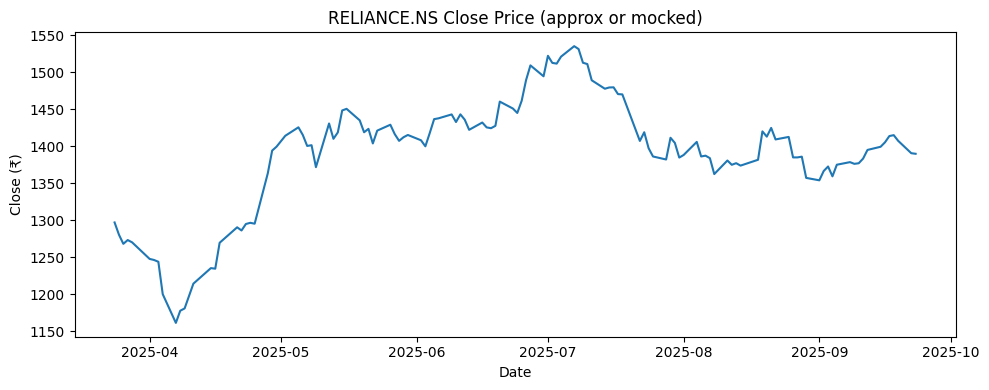

Evaluator Scores:
{'score': 1.0, 'coverage': 1.0, 'consistency': 1.0, 'actionable': 1.0, 'feedback': []}

=== FINAL REPORT ===

### RELIANCE.NS Research Note (India)
**Agent:** Analyst-India-Colab

**Plan:** Fetch prices for RELIANCE.NS, Fetch India-focused news for RELIANCE.NS, Assess macro background (CPI/WPI/Repo/INR), Route items to specialists and aggregate signals, Draft report → Evaluate → Optimize

**Prices available:** True; **News items:** 4; **Macro available:** True.

**Simple Returns:** 1M=Ticker
RELIANCE.NS    0.35
dtype: float64%, 3M=Ticker
RELIANCE.NS   -6.68
dtype: float64%, 6M=Ticker
RELIANCE.NS    7.16
dtype: float64% (approx).

**Routed Signals (samples):** [{'title': 'RIL announces green energy capex ramp-up; evaluates battery storage JV', 'route': 'earnings', 'result': {'eps_beat': False, 'eps_miss': False, 'guidance_mentioned': True}}, {'title': 'RBI keeps repo rate unchanged; stance remains withdrawal of accommodation', 'route': 'earnings', 'result': {'eps_beat'

In [9]:
agent = InvestmentResearchAgent(name="Analyst-India-Colab")
out = agent.run("RELIANCE.NS", period="6mo")

display(out["prices"].tail(5))

plt.figure(figsize=(10,4))
plt.plot(out["prices"]["date"], out["prices"]["Close"])  # single plot, default colors
plt.title("RELIANCE.NS Close Price (approx or mocked)")
plt.xlabel("Date")
plt.ylabel("Close (₹)")
plt.tight_layout()
plt.show()

print("Evaluator Scores:")
print(out["evaluation"])
print("\n=== FINAL REPORT ===\n")
print(out["final_report"])

## Team Collaboration Plan (3 Members)

👥 Team Contributions

## 👥 Team Contributions

### **Pavan Kumar Kallakuri — Agent Design & Workflow Implementation**

**Ownership & Scope**
- End-to-end **agent architecture** and research workflow (Prompt Chaining → Routing → Evaluator–Optimizer).
- Core orchestration: planning logic, run loop, memory, and self-reflection.

**Key Deliverables**
- `InvestmentResearchAgent` (planning/orchestration, run/evaluate/optimize cycle, memory persistence).
- **Routing** heuristics (`route_snippet_india`) to dispatch snippets to Earnings vs News specialists.
- **News prompt-chaining** pipeline:
  - `ingest_news_raw_india` → `preprocess_articles_india` → `classify_sentiment` → `extract_signals_india` → `summarize_articles_india`.
- **Evaluator–Optimizer**:
  - `evaluate_report` scoring (coverage, consistency, actionability).
  - `optimize_report` refinements (auto-add news/macro/monitor/risks).
- **Memory subsystem**:
  - `load_memory` / `save_memory` / `memorize` / `recall` (JSON notes per ticker).

**Design Decisions**
- Modular, testable functions; **pure data in/out** where possible.
- Lightweight rules-based sentiment & signal extraction for deterministic demos (no API keys).
- **Fail-safe runtime** (always completes with synthetic data + mocks).
- Clear separation of **agent reasoning** vs **tool I/O**.

**Quality & Documentation**
- PEP 8 naming, type hints where helpful, inline doctrings.
- Readable “story flow” in the notebook; section headers and banners.
- Warnings hardened (e.g., `.iloc[-1]`, explicit `auto_adjust=False`, timezone-aware timestamps).

**Handoffs & Collaboration**
- Defined **agent/tool interfaces** for data layer to plug in real NSE/RBI sources.
- Provided example usage + final report structure for reporting integration.

**Next Iterations (Owner)**
- Sector specialists (Banking/IT/O&G/FMCG) & richer routing.
- LLM-based evaluator for deeper accuracy checks and rationale explanations.

---

### **Sajesh Kariadan — Data Integration & Reporting**

**Ownership & Scope**
- **Data layer** (finance, news, macro) with robust fallbacks and consistent schemas.
- **Visual/reporting layer** (KPI chips, charts, export helpers) & repository hygiene.

**Key Deliverables**
- **Tool wrappers**:
  - `tool_finance_prices_nse` (yfinance OHLCV; synthetic series fallback).
  - `tool_news_search_india` (mock India news feed).
  - `tool_macro_india` (mock CPI/WPI/Repo/USDINR; datetime-safe parsing).
- **MarketAgent**:
  - `market_agent_india` (scalar extraction with `.iloc[-1]`, regime tagging, NaN/None safe).
- **Visualizations & UI**:
  - KPI chips card (`render_kpis`), **price chart** (`plot_price_chart`),
  - **News sentiment bars** (`plot_sentiment_bars`), **macro snapshot bars** (`plot_macro_bars`),
  - Evaluator table (`render_eval_table`) & collapsible final report (`render_final_report`).
  - Optional **widgets UI** (ticker/period combobox) and polished CSS/typography.
- **Export & Ops**:
  - `export_notebook_to_html` helper (nbconvert route).
  - Repo structure, README alignment, requirements curation.

**Engineering Decisions**
- **Always-runs philosophy**: graceful yfinance failures → synthetic series; mock feeds to avoid API keys.
- Schema normalization (consistent `date`/`value` fields); explicit float casts to avoid pandas ambiguity.
- Quieted warnings (auto_adjust, Series truth-value) & timezone-aware logging for memory notes.

**Quality & Documentation**
- Descriptive sectioning, banners, and callouts for layman usability.
- Clear separation of presentation (cards/charts) from core logic to ease maintenance.

**Next Iterations (Owner)**
- Plug-in adapters for **NSE corporate announcements**, RBI/NSO official series, and FPI flows.
- Dashboard packaging (Streamlit/Gradio) and HTML/PDF report templates.

---

### Module-to-Owner Map (Quick Reference)

| Area | Module / Function | Primary Owner |
|---|---|---|
| Orchestration & Memory | `InvestmentResearchAgent`, `load/save/memorize/recall` | **Pavan** |
| Prompt Chaining (News) | `ingest_*/preprocess_*/classify_sentiment/extract_signals_*/summarize_*` | **Pavan** |
| Routing & Specialists | `route_snippet_india`, `earnings_agent`, `market_agent_india` | **Pavan** (routing), **Sajesh** (market agent) |
| Finance Data | `tool_finance_prices_nse` (yfinance + synthetic fallback) | **Sajesh** |
| News/Macro Data | `tool_news_search_india`, `tool_macro_india` (mock) | **Sajesh** |
| Visuals & UI | KPI chips, price/sentiment/macro plots, eval table, final report UI | **Sajesh** |
| Export | `export_notebook_to_html` | **Sajesh** |



## GitHub Integration (Placeholder)
- **Repo:** `https://github.com/your-org/multi-agent-fin-research-nse` *(placeholder)*
- Include this notebook and a `README.md` describing: architecture, setup, API keys, contribution guide for Members A/B/C, and license.


## Export Options (HTML/PDF)
In Colab: *File → Print → Save as PDF* or use `nbconvert` (helper function below).

In [1]:
import sys, subprocess
def export_notebook_to_html(ipynb_path: str, output_path: str = "report.html"):
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "nbconvert", "jupyter"])
    except Exception:
        pass
    cmd = [sys.executable, "-m", "jupyter", "nbconvert", "--to", "html", ipynb_path, "--output", output_path]
    try:
        subprocess.check_call(cmd)
        print(f"Exported HTML → {output_path}")
    except Exception as e:
        print("Export failed:", e)
print("Call export_notebook_to_html('Financial_MultiAgent_Colab_NSE.ipynb', 'Financial_MultiAgent_Colab_NSE.html') after saving.")

Call export_notebook_to_html('Financial_MultiAgent_Colab_NSE.ipynb', 'Financial_MultiAgent_Colab_NSE.html') after saving.
